In [119]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import dlib
import urllib.request

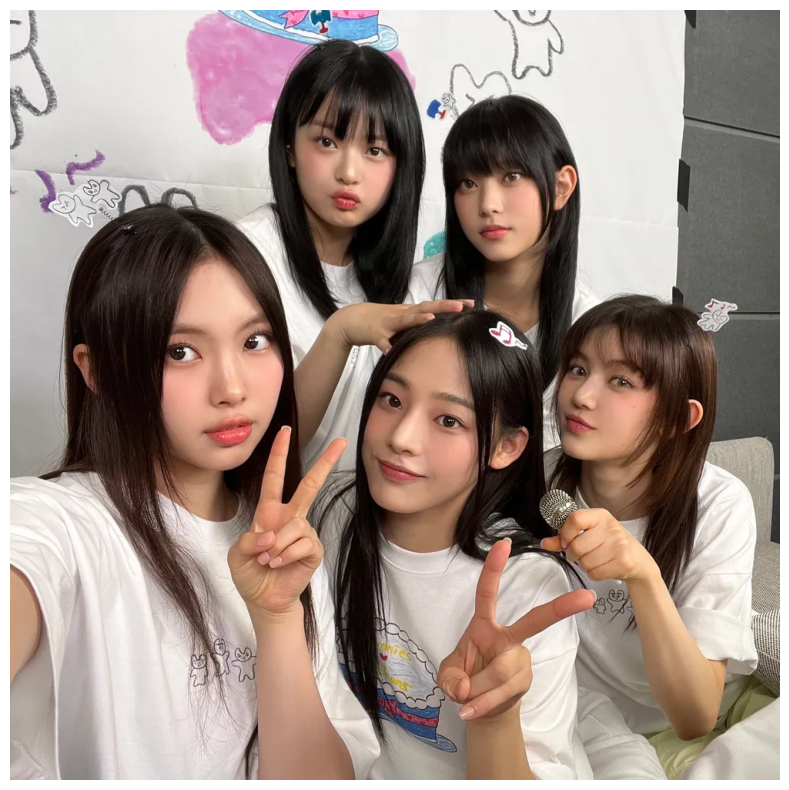

In [120]:

# 이미지 URL
url = "https://i.namu.wiki/i/0CgYU5VSFufGTtlw5sCu5PmNBSjncpe2DgV1dPHEdEvtNZu3cA56tvgxuLY4QU-G0izTGl35pTv7Ig-zG6sgyA.webp"

# User-Agent 헤더 추가
headers = {'User-Agent': 'Mozilla/5.0'}
req = urllib.request.Request(url, headers=headers)

# 이미지 다운로드
resp = urllib.request.urlopen(req)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)

# 이미지를 RGB로 변환
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image= image_rgb
# 이미지 출력
plt.figure(figsize=(19, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


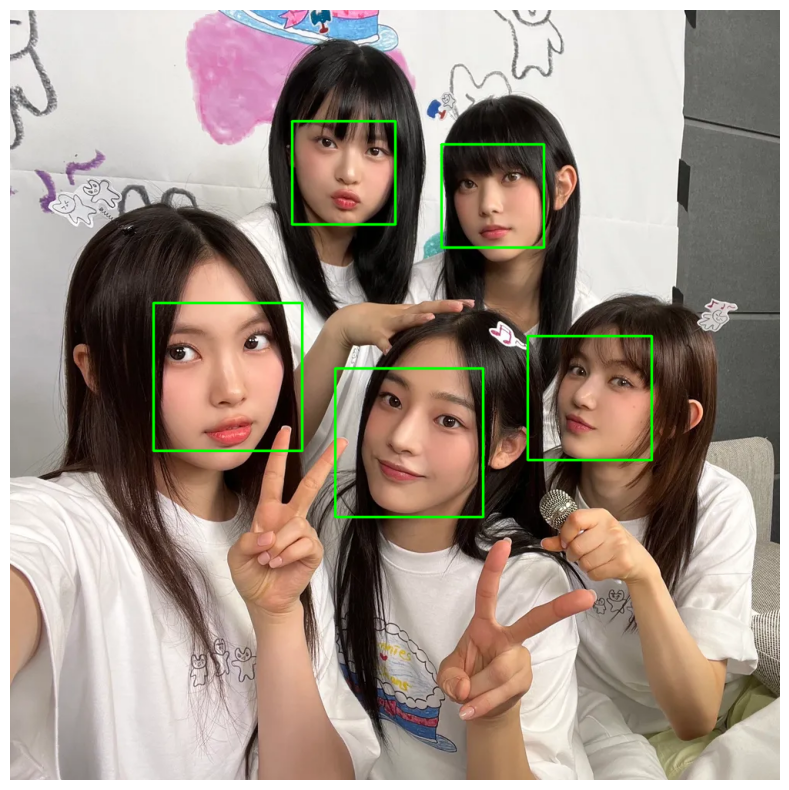

In [121]:

detector_hog = dlib.get_frontal_face_detector()

dlib_rects = detector_hog(image_rgb, 2) 

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(image_rgb, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA)

plt.figure(figsize=(19, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


In [122]:
weight_path = 'shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(weight_path)

In [123]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = predictor(image_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


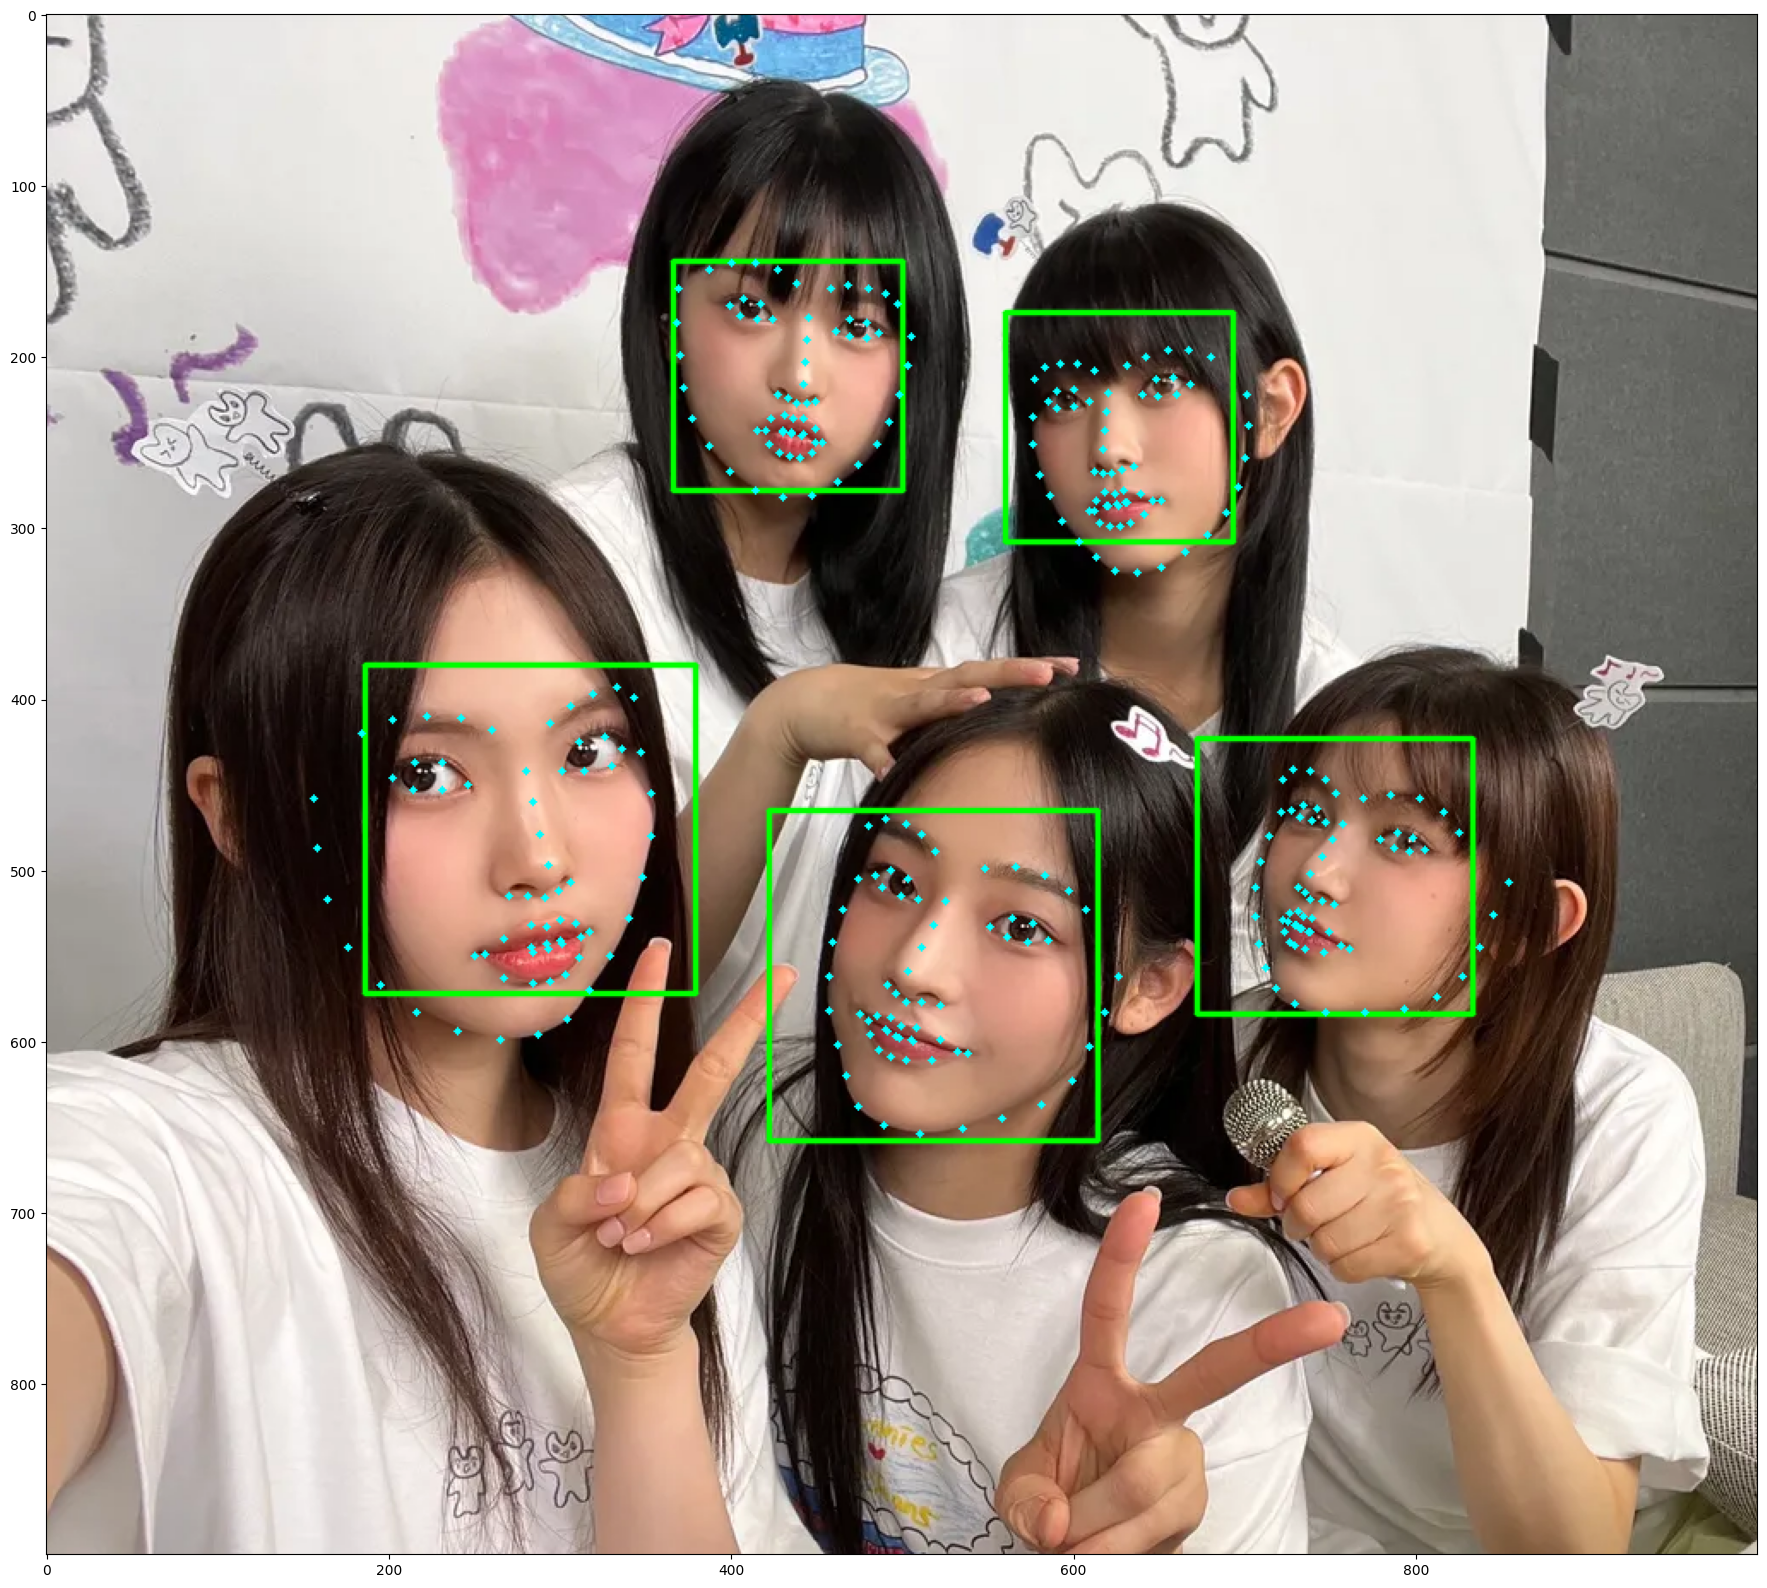

In [124]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(image_rgb, point, 2, (0, 255, 255), -1)

plt.figure(figsize=(38, 20))
plt.imshow(image_rgb[:900, :, :])
plt.show()

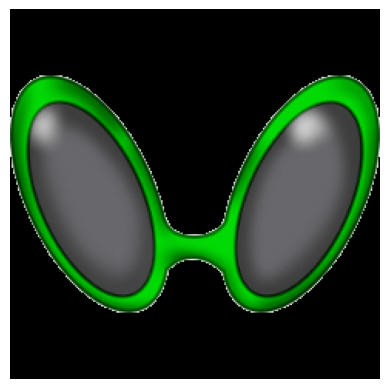

In [125]:
# 선글라스 이미지 불러오기
sunglass = cv2.imread('images_opencv/sunglass.png')  # 새로 업로드한 선글라스 이미지
sunglass = cv2.cvtColor(sunglass, cv2.COLOR_BGR2RGB)

# 흰색 배경을 투명하게 처리
sunglass_gray = cv2.cvtColor(sunglass, cv2.COLOR_RGB2GRAY)
_, mask = cv2.threshold(sunglass_gray, 240, 255, cv2.THRESH_BINARY_INV)
sunglass[np.where(mask == 0)] = 0

plt.imshow(sunglass)
plt.axis('off')
plt.show()

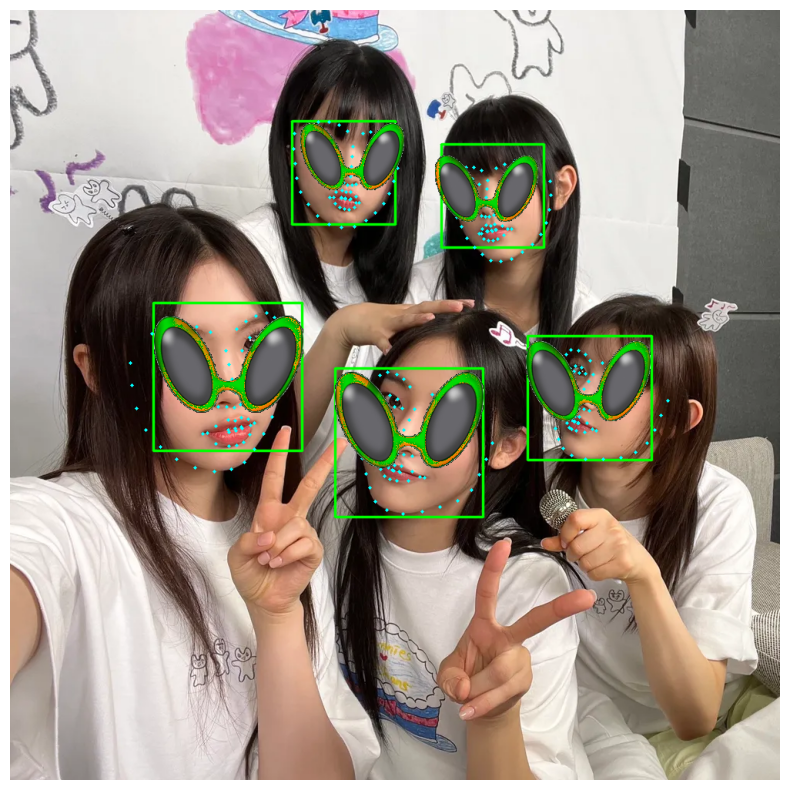

In [126]:
# 각 얼굴에 선글라스 합성하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # 선글라스를 눈 위에 배치 (왼쪽 눈의 중심 기준)
    x = landmark[28][0]
    y = landmark[28][1]
    w = dlib_rect.width()
    h = w * sunglass.shape[0] // sunglass.shape[1]  # 선글라스의 비율 유지
    
    # 선글라스 크기 조정
    resized_sunglass = cv2.resize(sunglass, (w, h))
    
    # 선글라스 위치 계산
    refined_x = x - w // 2
    refined_y = y - h // 2

    
    # 이미지 경계 처리
    if refined_x < 0:
        resized_sunglass = resized_sunglass[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        resized_sunglass = resized_sunglass[-refined_y:, :]
        refined_y = 0
    
    # 선글라스 합성
    sticker_area = image_rgb[refined_y:refined_y + resized_sunglass.shape[0], refined_x:refined_x + resized_sunglass.shape[1]]
    image[refined_y:refined_y + resized_sunglass.shape[0], refined_x:refined_x + resized_sunglass.shape[1]] = \
        np.where(resized_sunglass == 0, sticker_area, resized_sunglass).astype(np.uint8)

# 결과 이미지 출력
plt.figure(figsize=(19, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()